# Regression Analysis

## SmartHouse: AI-Powered Real Estate Price Predictor
### Predicting house prices with machine learning and actionable market insights

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [2]:
# Make plots look nice
plt.style.use("seaborn-v0_8")

In [5]:
DATA_PATH = "house_prices.csv"
np.random.seed(42)

In [4]:
def generate_synthetic_dataset(path=DATA_PATH, n=1000):
    size = np.round(np.random.uniform(300, 4000, n), 0)
    locations = np.random.choice(['urban', 'suburban', 'rural'], size=n, p=[0.45, 0.35, 0.20])
    rooms = np.random.randint(1, 8, n)
    base_pps = {'urban': 8000, 'suburban': 5000, 'rural': 2200}
    
    price = []
    for s, loc, r in zip(size, locations, rooms):
        pps = base_pps[loc]
        room_val = 30000 * (r - 1)
        val = s * pps + room_val + (s**0.8) * 50 + np.random.normal(0, 50000)
        price.append(max(100000, round(val)))
    
    df = pd.DataFrame({'Size': size, 'Location': locations, 'Number_of_Rooms': rooms, 'Price': price})
    for col in ['Size', 'Number_of_Rooms', 'Location']:
        df.loc[df.sample(frac=0.02, random_state=1).index, col] = np.nan
    df.to_csv(path, index=False)
    return df

# Load or generate dataset
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print("Loaded existing dataset.")
else:
    df = generate_synthetic_dataset(n=1200)
    print("Generated synthetic dataset.")

df.head()

Loaded existing dataset.


,Size,Location,Number_of_Rooms,Price
0,1686.0,suburban,3.0,8528609
1,3818.0,urban,7.0,30694357
2,3008.0,urban,7.0,24326676
3,2515.0,urban,3.0,20264746
4,877.0,suburban,6.0,4534838


In [8]:
print("Missing values:\n", df.isna().sum())

Missing values:
 Size               24
Location           24
Number_of_Rooms    24
Price               0
dtype: int64


In [9]:
display(df.describe(include='all'))

,Size,Location,Number_of_Rooms,Price
count,1176.000000,1176,1176.000000,1.200000e+03
unique,NaN,3,NaN,NaN
top,NaN,urban,NaN,NaN
freq,NaN,517,NaN,NaN
mean,2147.707483,NaN,3.941327,1.254349e+07
std,1090.683157,NaN,1.986112,8.217893e+06
min,317.000000,NaN,1.000000,6.877390e+05
25%,1180.500000,NaN,2.000000,5.783364e+06
50%,2178.000000,NaN,4.000000,1.088297e+07
75%,3104.250000,NaN,6.000000,1.851195e+07


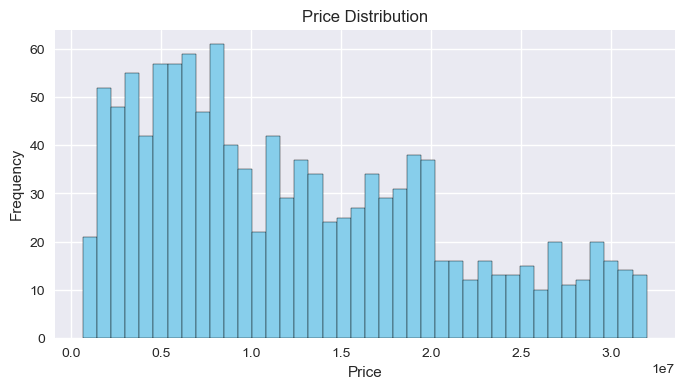

In [10]:
# Price distribution
plt.figure(figsize=(8,4))
plt.hist(df['Price'].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

<Figure size 800x500 with 0 Axes>

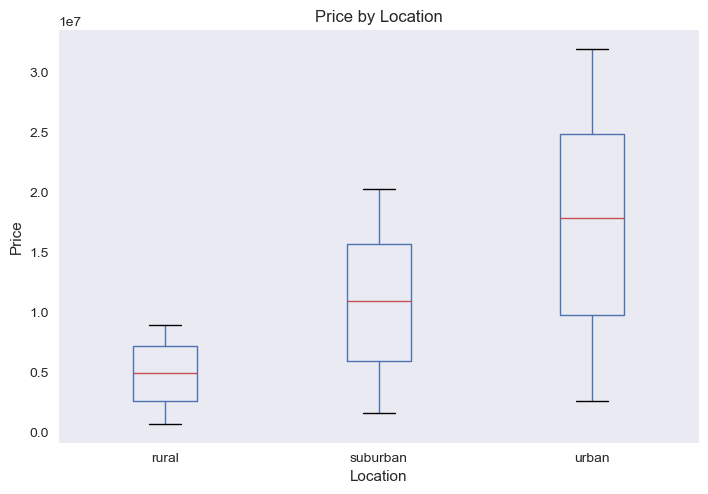

In [11]:
# Boxplot: Price by Location
plt.figure(figsize=(8,5))
df.boxplot(column='Price', by='Location', grid=False)
plt.title('Price by Location')
plt.suptitle('')
plt.ylabel('Price')
plt.show()

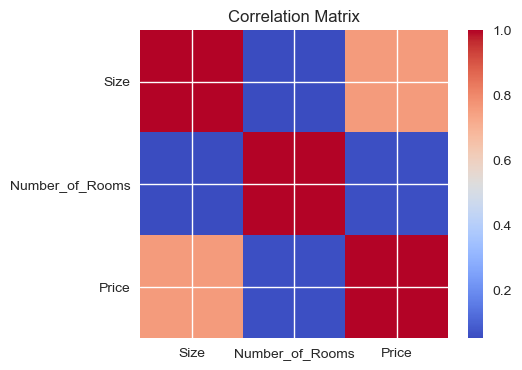

In [12]:
# Correlation matrix
corr = df[['Size','Number_of_Rooms','Price']].corr()
plt.figure(figsize=(5,4))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

In [13]:
numerical_features = ['Size', 'Number_of_Rooms']
categorical_features = ['Location']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [17]:
X = df[numerical_features + categorical_features]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000)
}

results = {}
best_pipeline = None
best_model_name = None
best_rmse = float("inf")

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae}
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_pipeline = pipe
        best_model_name = name

pd.DataFrame(results).T


,RMSE,R2,MAE
Linear,2.767559e+06,0.868814,2.042310e+06
Ridge,2.767744e+06,0.868797,2.042260e+06
Lasso,2.767559e+06,0.868814,2.042310e+06


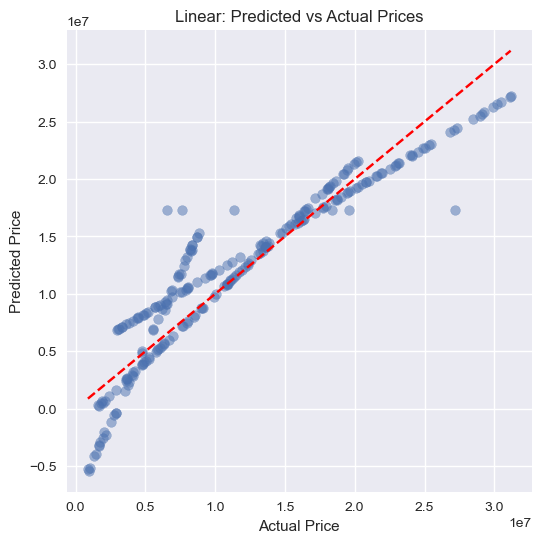

In [18]:
y_pred = best_pipeline.predict(X_test)

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'{best_model_name}: Predicted vs Actual Prices')
plt.show()

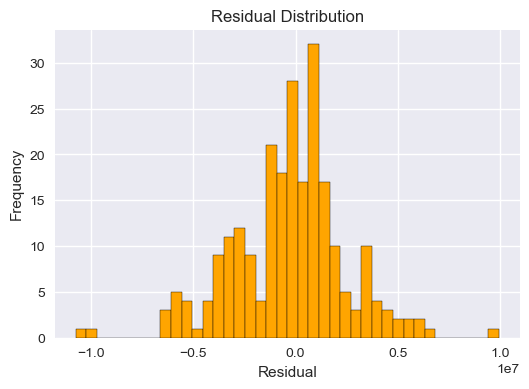

In [19]:
# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [20]:
joblib.dump(best_pipeline, "full_pipeline_model.pkl")
print("Model saved as full_pipeline_model.pkl")

Model saved as full_pipeline_model.pkl
